In [1]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
print("Processing......")


Processing......


In [5]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

print("Processing.....")

Processing.....


In [7]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [8]:
df = df.sort_values('Date')

In [9]:
df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42
5,2010-07-21,0.07921,0.08181,0.05050,0.05050,0.05050,129
6,2010-07-22,0.05050,0.06767,0.05050,0.06262,0.06262,141
7,2010-07-23,0.06262,0.06161,0.05049,0.05454,0.05454,26
8,2010-07-24,0.05454,0.05941,0.05050,0.05050,0.05050,85
9,2010-07-25,0.05050,0.05600,0.05000,0.05600,0.05600,46


In [7]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

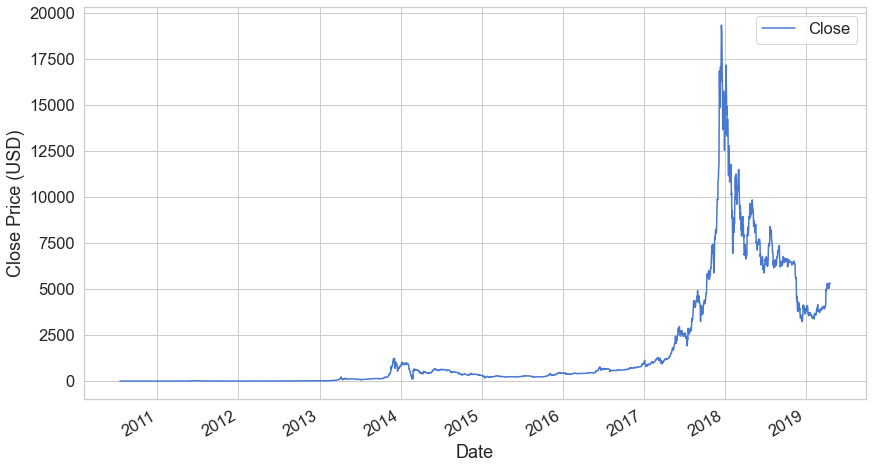

In [83]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(3201, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [12]:
scaled_close = scaled_close.reshape(-1, 1)

In [13]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(2945, 99, 1)

In [16]:
X_test.shape

(156, 99, 1)

# Model

In [17]:
DROPOUT = 0.2
## drops out some nodes of the network here 20% of nodes are dropout to avoid overfitting.

WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
##Implements the sequential model approach.

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
##Showing the bidirectional nature of LSTM showing both direction Backward(future to past) or Forward(past to future).

model.add(Dropout(rate=DROPOUT))
##  Dropout is a technique where randomly selected neurons are ignored during training.


model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
 ## WindOW_SIZE-----------used to set the size of the  window.
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))                  #To add a hidden layer

model.add(Activation('linear'))            # Add linear Activation fuction 

# Training

In [18]:
model.compile(
    loss='mse', 
    optimizer='adam',
)

In [19]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 61s 1s/step - loss: 0.0019 - val_loss: 0.0116
Epoch 2/50
42/42 [==============================] - 55s 1s/step - loss: 0.0097 - val_loss: 0.0019
Epoch 3/50
42/42 [==============================] - 55s 1s/step - loss: 0.0057 - val_loss: 0.0059
Epoch 4/50
42/42 [==============================] - 56s 1s/step - loss: 0.0032 - val_loss: 0.0273
Epoch 5/50
42/42 [==============================] - 61s 1s/step - loss: 0.0164 - val_loss: 0.0402
Epoch 6/50
42/42 [==============================] - 58s 1s/step - loss: 0.0024 - val_loss: 0.0093
Epoch 7/50
42/42 [==============================] - 57s 1s/step - loss: 0.0083 - val_loss: 0.0609
Epoch 8/50
42/42 [==============================] - 57s 1s/step - loss: 0.0651 - val_loss: 0.0022
Epoch 9/50
42/42 [==============================] - 61s 1s/step - loss: 0.0103 - val_loss: 0.0388
Epoch 10/50
42/42 [==============================] - 61s 1s/step - loss: 0.0245 - val_loss: 0.0042
Epoch 11/50
42/42 [

In [21]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 174ms/step - loss: 0.0015


0.001521530095487833

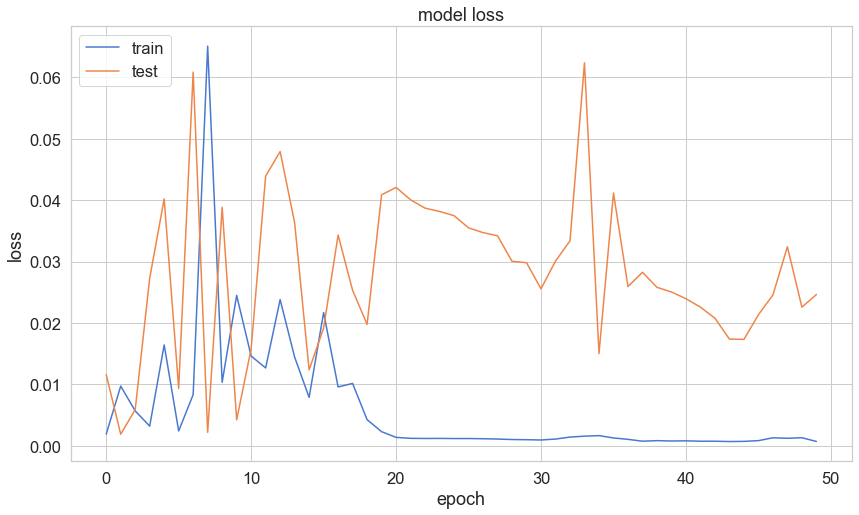

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

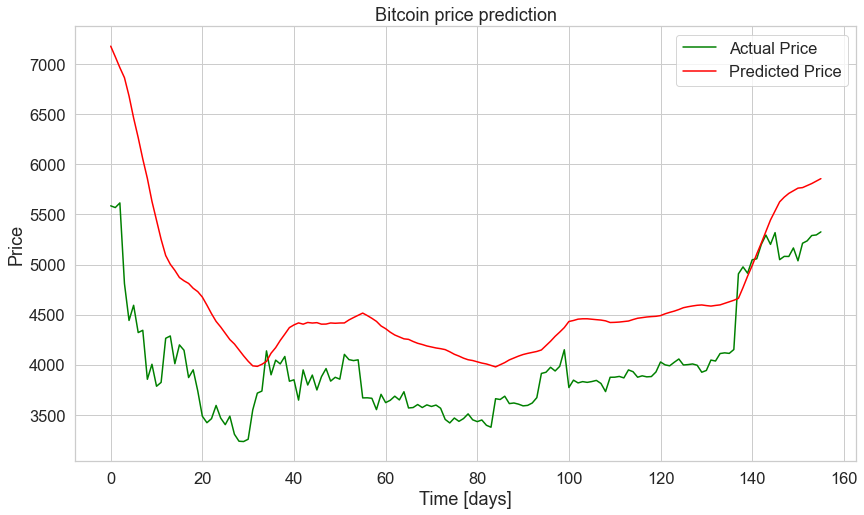

In [23]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [2]:
prediction_results=get_prediction_results(X_train,y_train,model)
prediction_results['Predition success'].mean()


NameError: name 'get_prediction_results' is not defined